In [68]:
import os
from pathlib import Path
import argparse
import shutil

import cv2
from imutils import paths
from matplotlib import pyplot as plt
import numpy as np


In [26]:
DATA_PATH = Path("../data/")
RAW_DATA_PATH = DATA_PATH / "raw_samples"
RAW_LABELS_PATH = DATA_PATH / "raw_labels"

The dataset is https://store.mut1ny.com/product/face-head-segmentation-dataset-community-edition?v=2fe3d42cf0b9

After downloading it and unzipping, there was a quick manual adjustment.
The `labels` folder is renamed `raw_labels`. And then the other image folder are move to a new folder `raw_samples`.

Additionally to the images and labels (masks), the data contains a `training.xml` mapping the images to the labels images.

# Pair img and label paths
Based on provided `training.xml` file.

In [58]:
import xml.etree.ElementTree as ET
tree = ET.parse(DATA_PATH / "training.xml")
root = tree.getroot()

In [75]:
data_paths = []
continue_next = False
for child in root:
    if continue_next:
        continue_next = False
        continue

    if child.tag == "srcimg":
        img_path = RAW_DATA_PATH / child.attrib['name'].replace("\\", "/")
        
        if not img_path.exists():
            print("File doesn't exist:", img_path)
            continue_next = True
            continue
            
    elif child.tag == "labelimg":

        parsed_string = child.attrib['name'].replace("\\", "/").replace("labels/", "")
        label_path = RAW_LABELS_PATH / parsed_string
        assert labels_path.exists()

        data_paths.append((img_path, label_path))


File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env3/headrende0318.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env3/headrende0324.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env3/headrende0336.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env3/headrende0339.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env3/headrende0342.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env3/headrende0345.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env3/headrende0348.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env4/headrende0318.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env4/headrende0322.png
File doesn't exists ../data/raw_samples/male06_greyeyes_brownhair_nolight_env4/headrende0324.png
File doesn't exists ../data/ra

# Reorganize the data
Into the categories: female, male, multiperson, and real

In [73]:
SAMPLES_PATH = DATA_PATH / "samples"
LABELS_PATH = DATA_PATH / "labels"

In [77]:
for img_file, label_file in data_paths:
    
    if img_file.parent.name.startswith("female"):
        folder = "female"
    elif img_file.parent.name.startswith("male"):
        folder = "male"
    elif img_file.parent.name.startswith("multiperson"):
        folder = "multiperson"
    elif img_file.parent.name.startswith("real"):
        folder = "real"
    else:
        raise ValueError(f"Unhandled folder {folder}")

    # copy the sample
    target_sample_dir = SAMPLES_PATH / folder / img_file.parent.name
    target_sample_dir.mkdir(exist_ok=True, parents=True)
    target_sample_file = target_sample_dir / img_file.name
    shutil.copy(img_file, target_sample_file)

    # copy the mask
    target_label_dir = LABELS_PATH / folder / img_file.parent.name
    target_label_dir.mkdir(exist_ok=True, parents=True)
    target_label_file = target_label_dir / img_file.name
    shutil.copy(label_file, target_label_file)


# Remove near duplicates

In [79]:
image_paths = list(paths.list_images(SAMPLES_PATH))
len(image_paths)

16286

In [80]:
def dhash(image, hashSize=8):
    """https://pyimagesearch.com/2017/11/27/image-hashing-opencv-python/"""
    # convert the image to grayscale and resize the grayscale image,
    # adding a single column (width) so we can compute the horizontal
    # gradient
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hashSize + 1, hashSize))
    # compute the (relative) horizontal gradient between adjacent
    # column pixels
    diff = resized[:, 1:] > resized[:, :-1]
    # convert the difference image to a hash and return it
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])


hashes = {}
# loop over our image paths
for image_path in image_paths:
    # load the input image and compute the hash
    image = cv2.imread(image_path)
    h = dhash(image)
    # grab all image paths with that hash, add the current image
    # path to it, and store the list back in the hashes dictionary
    p = hashes.get(h, [])
    p.append(image_path)
    hashes[h] = p

(array([204.,   5.,   2.,   3.,   0.,   2.,   2.,   0.,   1.,   1.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

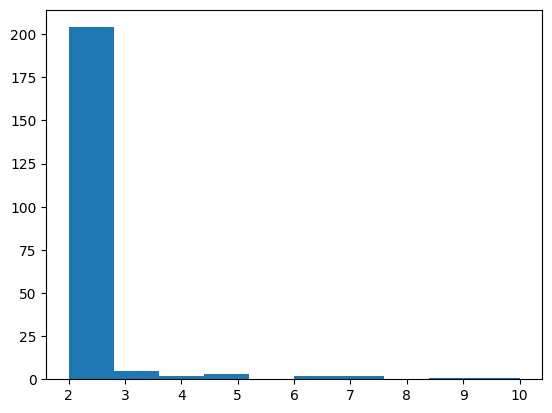

In [20]:
duplicates = [len(hashed_paths) for hashed_paths in hashes.values() if len(hashed_paths) > 1]
plt.hist(duplicates) 

As we can see above there are a few duplicates in the dataset, so the following code is going through the hashes with more than one match and deleting everything but the first appearance. 

In [82]:
remove = True
# loop over the image hashes and remove duplicates
for h, hashed_paths in hashes.items():
    # check to see if there is more than one image with the same hash
    if len(hashed_paths) > 1:
        # check to see if this is a dry run
        if not remove:
            # initialize a montage to store all images with the same
            # hash
            montage = None
            # loop over all image paths with the same hash
            for p in hashed_paths:
                # load the input image and resize it to a fixed width
                # and heightG
                image = cv2.imread(p)
                image = cv2.resize(image, (150, 150))
                # if our montage is None, initialize it
                if montage is None:
                    montage = image
                # otherwise, horizontally stack the images
                else:
                    montage = np.hstack([montage, image])
            # show the montage for the hash
            print("[INFO] hash: {}".format(h))
            plt.imshow(montage)
            plt.show()
        # otherwise, we'll be removing the duplicate images
        else:
            # loop over all image paths with the same hash *except*
            # for the first image in the list (since we want to keep
            # one, and only one, of the duplicate images)
            for p in hashed_paths[1:]:
                os.remove(p)
         

In [83]:
image_paths = list(paths.list_images(SAMPLES_PATH))
len(image_paths)

16286